In [0]:
!pip install fastprogress==0.1.20

ERROR: fastai 1.0.60 has requirement fastprogress>=0.2.1, but you'll have fastprogress 0.1.20 which is incompatible.
  Found existing installation: fastprogress 0.2.2
    Uninstalling fastprogress-0.2.2:
      Successfully uninstalled fastprogress-0.2.2


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import tensorflow as tf
from tqdm import tqdm

import math
import torch.nn.functional as F
from sklearn.metrics import f1_score, mean_squared_error
from fastprogress import master_bar, progress_bar

%matplotlib inline

In [0]:
BATCH_SIZE = 1                          
LEARNING_RATE = 0.001
LEARNING_RATE_SCHEDULE_FACTOR = 0.1           # Parameter used for reducing learning rate
LEARNING_RATE_SCHEDULE_PATIENCE = 5           # Parameter used for reducing learning rate
MAX_EPOCHS = 100                              # Maximum number of training epochs

# Input List of Dataset

In [0]:
PATH_FOLDER = '/content/drive/My Drive/Beat-PD/List_train_test'

def read_lst(file_name):
    list_ = []
    with open(file_name) as f:
        for element in f:
            list_.append(element.split('\n')[0])
        f.close()
    return list_ 

In [0]:
train_list_dyskinesia = read_lst(os.path.join(PATH_FOLDER, 'train_train_nonan_dyskinesia.lst'))
train_list_tremor = read_lst(os.path.join(PATH_FOLDER, 'train_train_nonan_tremor.lst'))
train_list_on_off = read_lst(os.path.join(PATH_FOLDER, 'train_train_nonan_on_off.lst'))

In [0]:
val_list_dyskinesia = read_lst(os.path.join(PATH_FOLDER, 'train_val_nonan_dyskinesia.lst'))
val_list_tremor = read_lst(os.path.join(PATH_FOLDER, 'train_val_nonan_tremor.lst'))
val_list_on_off = read_lst(os.path.join(PATH_FOLDER, 'train_val_nonan_on_off.lst'))

# Data Preprocessing

In [0]:
LABEL_PATH = '/content/drive/My Drive/Beat-PD/Train_Dataset/Data_Train_CIS-PD/Data_Train_CIS-PD/cis-pd.data_labels/data_labels/CIS-PD_Training_Data_IDs_Labels.csv'
LABEL_DF = pd.read_csv(LABEL_PATH)
# LABEL_DF.dropna(axis=0, inplace=True)
LABEL_DF.head()

,measurement_id,subject_id,on_off,dyskinesia,tremor
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1004,1.0,1.0,1.0
1,5163afe8-a6b0-4ea4-b2ba-9b4501dd5912,1004,0.0,0.0,0.0
2,5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a,1004,1.0,1.0,1.0
3,fb188ae2-2173-4137-9236-19a137a402c2,1004,3.0,3.0,3.0
4,19a3e9ea-fce1-40b7-9457-2618970beb7b,1004,1.0,1.0,1.0


In [0]:
TRAIN_PATH = '/content/drive/My Drive/Beat-PD/Train_Dataset/Data_Train_CIS-PD/Data_Train_CIS-PD/cis-pd.training_data/training_data/' 
LABEL_PATH = '/content/drive/My Drive/Beat-PD/Train_Dataset/Data_Train_CIS-PD/Data_Train_CIS-PD/cis-pd.data_labels/data_labels/CIS-PD_Training_Data_IDs_Labels.csv'

def preprocessing(name, train_path):
    # Get data for training
    df = pd.read_csv(os.path.join(train_path, name + '.csv'))
    df.drop('Timestamp', axis=1, inplace=True)
    data = torch.tensor(df.values).float()
    data = torch.unsqueeze(data, 0)
    data = torch.unsqueeze(data, 0)

    # Get label for training
    label = LABEL_DF.loc[LABEL_DF['measurement_id'] == name, ['on_off', 'dyskinesia', 'tremor']]
    label = torch.tensor(label.values).long()
    return data, label

# Create DataGenerator

In [0]:
class fundus_dataset(Dataset):
    def __init__(self, path_folder_csv, file_names, path_label_csv):
        super().__init__()

        self.folder = path_folder_csv
        self.file_names = file_names
        self.label_df = pd.read_csv(path_label_csv)

    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, index):
        # Get data for training
        df = pd.read_csv(os.path.join(self.folder, self.file_names[index] + '.csv'))
        df.drop('Timestamp', axis=1, inplace=True)
        data = torch.tensor(df.values).float()
        data = torch.unsqueeze(data, 0)
        data = torch.unsqueeze(data, 0)

        # Get label for training
        label = self.label_df.loc[self.label_df['measurement_id'] == self.file_names[index], ['dyskinesia']]
        label = torch.tensor(label.values[0]).long()
        return data, label

In [0]:
train_dataset = fundus_dataset(TRAIN_PATH, train_list_dyskinesia, LABEL_PATH)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)

In [0]:
val_dataset = fundus_dataset(TRAIN_PATH, val_list_dyskinesia, LABEL_PATH)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8,  pin_memory=True)

# Design Model

In [0]:
class Model_1(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.out_conv1 = 64
        self.out_conv2 = 128
        self.num_classes = num_classes

        # extract features
        conv1 = nn.Conv2d(in_channels=1, out_channels=self.out_conv1, kernel_size=(10, 3), stride=(1, 1), padding=(1,1))
        conv2 = nn.Conv2d(in_channels=self.out_conv1, out_channels=self.out_conv2, kernel_size=(5, 3), stride=(5, 3))
        # extract relationship between each features
        LSTM1 = nn.LSTM(input_size = 1, hidden_size = 1, num_layers=1)

        # sequential
        self.cnn = nn.Sequential(
            conv1, nn.ReLU(), 
            conv2, nn.ReLU()) 
        
        self.lstm = nn.Sequential( 
            LSTM1)

        self.fc = nn.Sequential(
            nn.Linear(self.out_conv2, num_classes))

    def forward(self, input):

        x1 = self.cnn(input).transpose(1, 2).view(-1, self.out_conv2, 1)
        # print(x1.shape)
        x2, hc_t = self.lstm(x1)
        # print(x2.shape)
        x3 = x2[-1].view(self.out_conv2)
        # print(x3.shape)
        x4 = self.fc(x3)
        # print(x4.shape)
        return x4


In [0]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [0]:
model = Model_1(num_classes = 5).to(device)
model

Model_1(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(10, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(5, 3), stride=(5, 3))
    (3): ReLU()
  )
  (lstm): Sequential(
    (0): LSTM(1, 1)
  )
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=5, bias=True)
  )
)

In [0]:
# x, y = train_dataset[0]
# model(x.to(device))

# Loss and Optim

In [0]:
loss = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), 
                   lr=LEARNING_RATE, 
                   betas=(0.9, 0.999), 
                   eps=1e-8, 
                   weight_decay=1e-5)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                    factor = LEARNING_RATE_SCHEDULE_FACTOR, 
                                                    patience = LEARNING_RATE_SCHEDULE_PATIENCE, 
                                                    mode = 'min',
                                                    verbose=True)

# Training each epoch

In [0]:
def epoch_training(epoch, model, train_dataset, device, loss_criteria, optimizer, mb):
    model.train()
    training_loss = 0

    for batch, (x, y) in enumerate(progress_bar(train_dataset, parent=mb)):
        x = x.to(device).squeeze(0)
        y = y.to(device).squeeze(0)

        optimizer.zero_grad()

        yhat = model(x)
        yhat = torch.unsqueeze(yhat, 0)
        loss = loss_criteria(yhat, y)

        loss.backward()
        optimizer.step()

        training_loss += loss.item()
        mb.child.comment = f'Training loss {training_loss/(batch+1)}'

    del x, y, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()

    return training_loss/len(train_dataset)

# Evaluate Model

In [0]:
def evaluating(epoch, model, val_dataset, device, loss_criteria, mb):
    model.eval()
    
    val_loss = 0                                  
    out_pred = torch.FloatTensor().to(device)      
    out_label = torch.FloatTensor().to(device)        

    with torch.no_grad(): 
        for step, (x, y) in enumerate(progress_bar(val_dataset, parent=mb)):
            x = x.to(device).squeeze(0)
            y = y.to(device).squeeze(0)

            out_label = torch.cat((out_label,  y.float()), 0)

            yhat = model(x)
            yhat = torch.unsqueeze(yhat, 0)
            loss = loss_criteria(yhat, y)

            out_pred = torch.cat((out_pred, torch.argmax(yhat).float()), 0)

            val_loss += loss
            mb.child.comment = f'Validation loss {val_loss/(step+1)}'

    del x, y, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()

    return val_loss/len(val_dataset), np.array(mean_squared_error(out_label.cpu(), out_pred.cpu())).mean()

# Fully Training

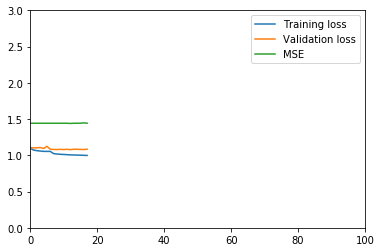

Epoch     7: reducing learning rate of group 0 to 1.0000e-04.
Buffered data was truncated after reaching the output size limit.

In [0]:
best_mse = 10
model_path = '/content/drive/My Drive/Beat-PD/CNN-LSTM-FC/pretrained_model/model_2.pth'
train_losses = []
val_losses = []
mse_arr = []

mb = master_bar(range(MAX_EPOCHS))
mb.names = ['Training loss', 'Validation loss', 'MSE']
x = []

for epoch in mb:
    mb.first_bar.comment = f'Best MSE: {best_mse}'
    x.append(epoch)

    train_loss = epoch_training(epoch, model, train_dataloader, device, loss, optimizer, mb)
    train_losses.append(train_loss)

    val_loss, mse = evaluating(epoch, model, val_dataloader, device, loss, mb)
    val_losses.append(val_loss)
    mse_arr.append(mse)

    lr_scheduler.step(mse)

    mb.update_graph([[x, train_losses], [x, val_losses], [x, mse_arr]], [0,MAX_EPOCHS], [0, 2])

    if best_mse > mse:
        mb.write(f"Improve MSE from {best_mse} to {mse}")
        best_mse = mse
        torch.save(model.state_dict(), model_path)

In [0]:
print("Best MSE = ",best_mse)

1.439776


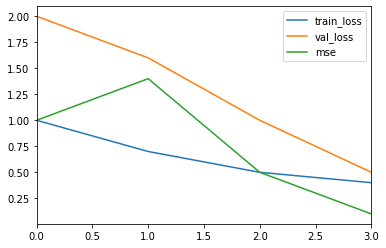

In [4]:
new_df = pd.DataFrame({"train_loss": train_losses,
                       "val_loss": val_losses,
                       "mse": mse_arr})
new_df.plot(kind="line")
plt.show()